#gradient clipping and Batch Normalisation

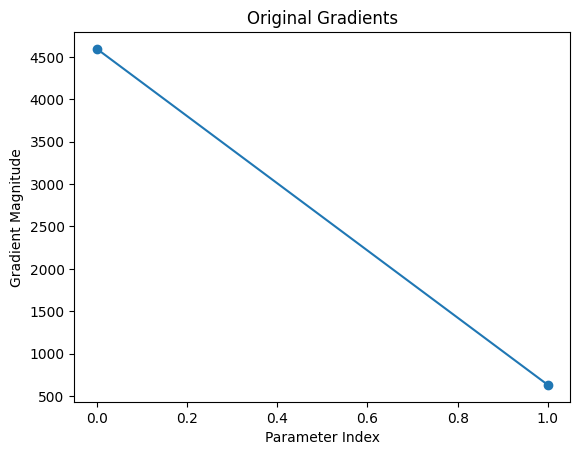

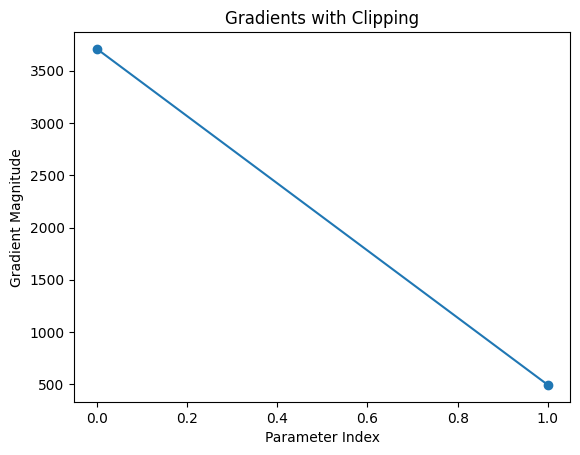

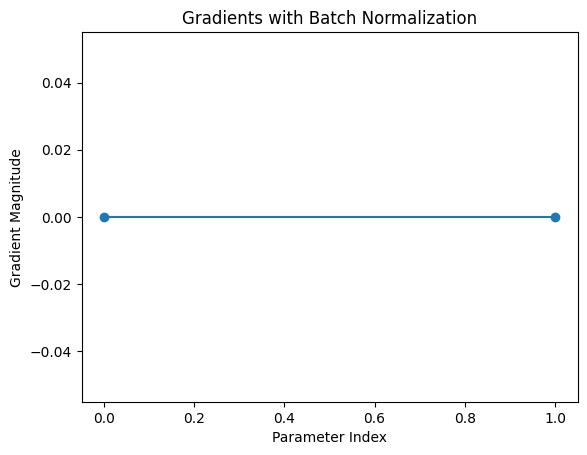

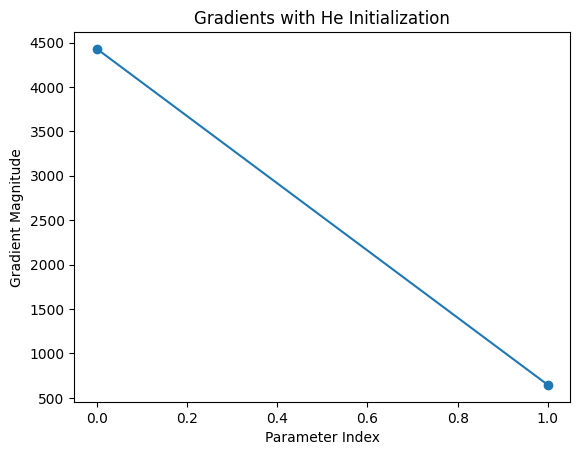

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load a dataset (for example, MNIST)
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train)

# Define a simple neural network
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(784,), kernel_initializer='he_normal'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Function to train a model and collect gradients
def train_and_collect_gradients(model, epochs, optimizer, clipping=None, batch_norm=False):
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())

    if clipping:
        optimizer = tf.keras.optimizers.SGD(clipvalue=clipping)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy')

    class GradientCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            layer = self.model.layers[0]  # Assume the first layer
            with tf.GradientTape() as tape:
                predictions = self.model(x_train)
                loss = tf.keras.losses.categorical_crossentropy(y_train, predictions)
            gradients = tape.gradient(loss, layer.trainable_weights)
            self.gradients = [np.linalg.norm(grad.numpy()) for grad in gradients]

    gradient_callback = GradientCallback()
    history = model.fit(x_train, y_train, epochs=epochs, callbacks=[gradient_callback], verbose=0)

    return history, gradient_callback.gradients

# Plot function
def plot_gradients(gradients, title):
    plt.plot(gradients, marker='o')
    plt.title(title)
    plt.xlabel('Parameter Index')
    plt.ylabel('Gradient Magnitude')
    plt.show()

# Experiment with different techniques
epochs = 5

# Original Model (Without Techniques)
original_model = create_model()
_, original_gradients = train_and_collect_gradients(original_model, epochs, tf.keras.optimizers.SGD(lr=1.0))
plot_gradients(original_gradients, 'Original Gradients')

# Model with Gradient Clipping
clipped_model = create_model()
_, clipped_gradients = train_and_collect_gradients(clipped_model, epochs, tf.keras.optimizers.SGD(lr=1.0), clipping=0.5)
plot_gradients(clipped_gradients, 'Gradients with Clipping')

# Model with Batch Normalization
bn_model = create_model()
_, bn_gradients = train_and_collect_gradients(bn_model, epochs, tf.keras.optimizers.SGD(lr=1.0), batch_norm=True)
plot_gradients(bn_gradients, 'Gradients with Batch Normalization')

# Model with He Initialization
he_model = create_model()
_, he_gradients = train_and_collect_gradients(he_model, epochs, tf.keras.optimizers.SGD(lr=1.0))
plot_gradients(he_gradients, 'Gradients with He Initialization')


# skip connection

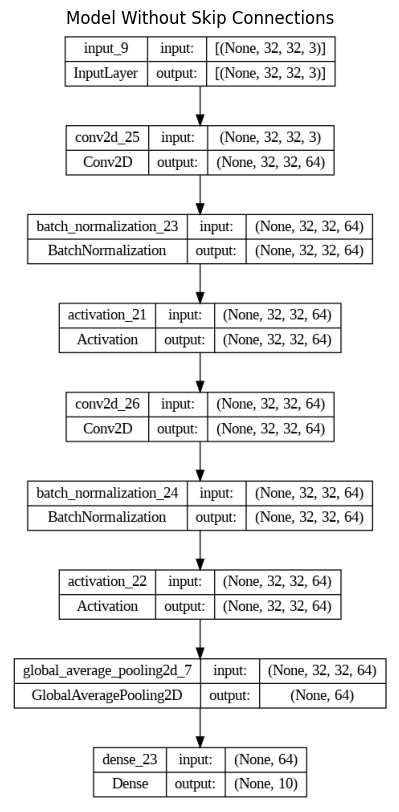

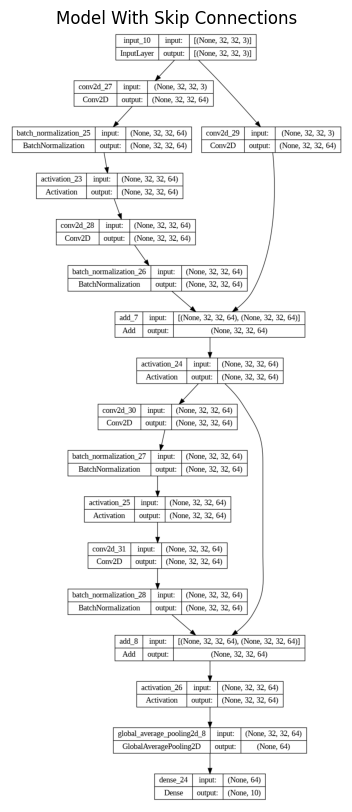

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Function to create a basic block without skip connection
def basic_block_without_skip(x, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# Function to create a basic block with skip connection
def basic_block_with_skip(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save the input for the skip connection

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Skip connection: Adjust the dimensions of the shortcut to match the output
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)

    # Skip connection: Add the input to the output of the second convolution
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

# Function to create a simple neural network without skip connections
def build_model_without_skip():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = basic_block_without_skip(inputs, 64)
    x = basic_block_without_skip(x, 64)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# Function to create a simple neural network with skip connections
def build_model_with_skip():
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = basic_block_with_skip(inputs, 64)
    x = basic_block_with_skip(x, 64)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

# Plot model architecture
def plot_model(model, title):
    tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file=f"{title}.png")
    img = plt.imread(f"{title}.png")
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Build and plot models
model_without_skip = build_model_without_skip()
plot_model(model_without_skip, 'Model Without Skip Connections')

model_with_skip = build_model_with_skip()
plot_model(model_with_skip, 'Model With Skip Connections')
